# 02 — Helmholtz Decomposition & QG Omega

Demonstrates on a real blocking event:

1. 3-D Helmholtz decomposition of anomalous winds → rotational / divergent / harmonic
2. QG omega equation solver
3. Moist / dry omega decomposition

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from pvtend import helmholtz_decomposition, R_EARTH
from pvtend.helmholtz import helmholtz_decomposition_3d
from pvtend.omega import solve_qg_omega
from pvtend.moist_dry import decompose_omega

## 1  Load event data

In [12]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"
d = dict(np.load(f"{DATA_ROOT}/blocking_tmp/onset/dh=+0/track_10_1990030505_dh+0.npz"))

lat = d["lat_vec"]
lon = d["lon_vec_unwrapped"]
levels = d["levels"]
X_rel, Y_rel = d["X_rel"], d["Y_rel"]
print(f"Grid: {lat.shape[0]}×{lon.shape[0]}, {len(levels)} levels")

Grid: 29×49, 9 levels


## 2  Helmholtz decomposition of anomalous wind

In [13]:
u_anom_3d = d["u_anom_3d"]   # (9, 29, 49)
v_anom_3d = d["v_anom_3d"]

result_3d = helmholtz_decomposition_3d(u_anom_3d, v_anom_3d, lat, lon, method="direct")
print("Helmholtz output keys:", sorted(result_3d.keys()))

Helmholtz output keys: ['chi', 'divergence', 'psi', 'u_div', 'u_har', 'u_rot', 'v_div', 'v_har', 'v_rot', 'vorticity']


In [14]:
# Compare with pre-computed NPZ values at 300 hPa
ilev = np.argmin(np.abs(levels - 300))

for comp in ["u_rot", "v_rot", "u_div", "v_div"]:
    npz_key = f"u_anom_{comp.split('_')[1]}_3d" if comp.startswith("u") else f"v_anom_{comp.split('_')[1]}_3d"
    computed = result_3d[comp][ilev]
    stored   = d[npz_key][ilev]
    relerr   = np.nanmean(np.abs(computed - stored)) / (np.nanmean(np.abs(stored)) + 1e-30)
    print(f"  {comp:6s}  rel-err = {relerr:.4e}")

  u_rot   rel-err = 3.6563e-01
  v_rot   rel-err = 4.8542e-01
  u_div   rel-err = 7.4916e-01
  v_div   rel-err = 7.5242e-01


## 3  Visualise rotational vs divergent wind at 300 hPa

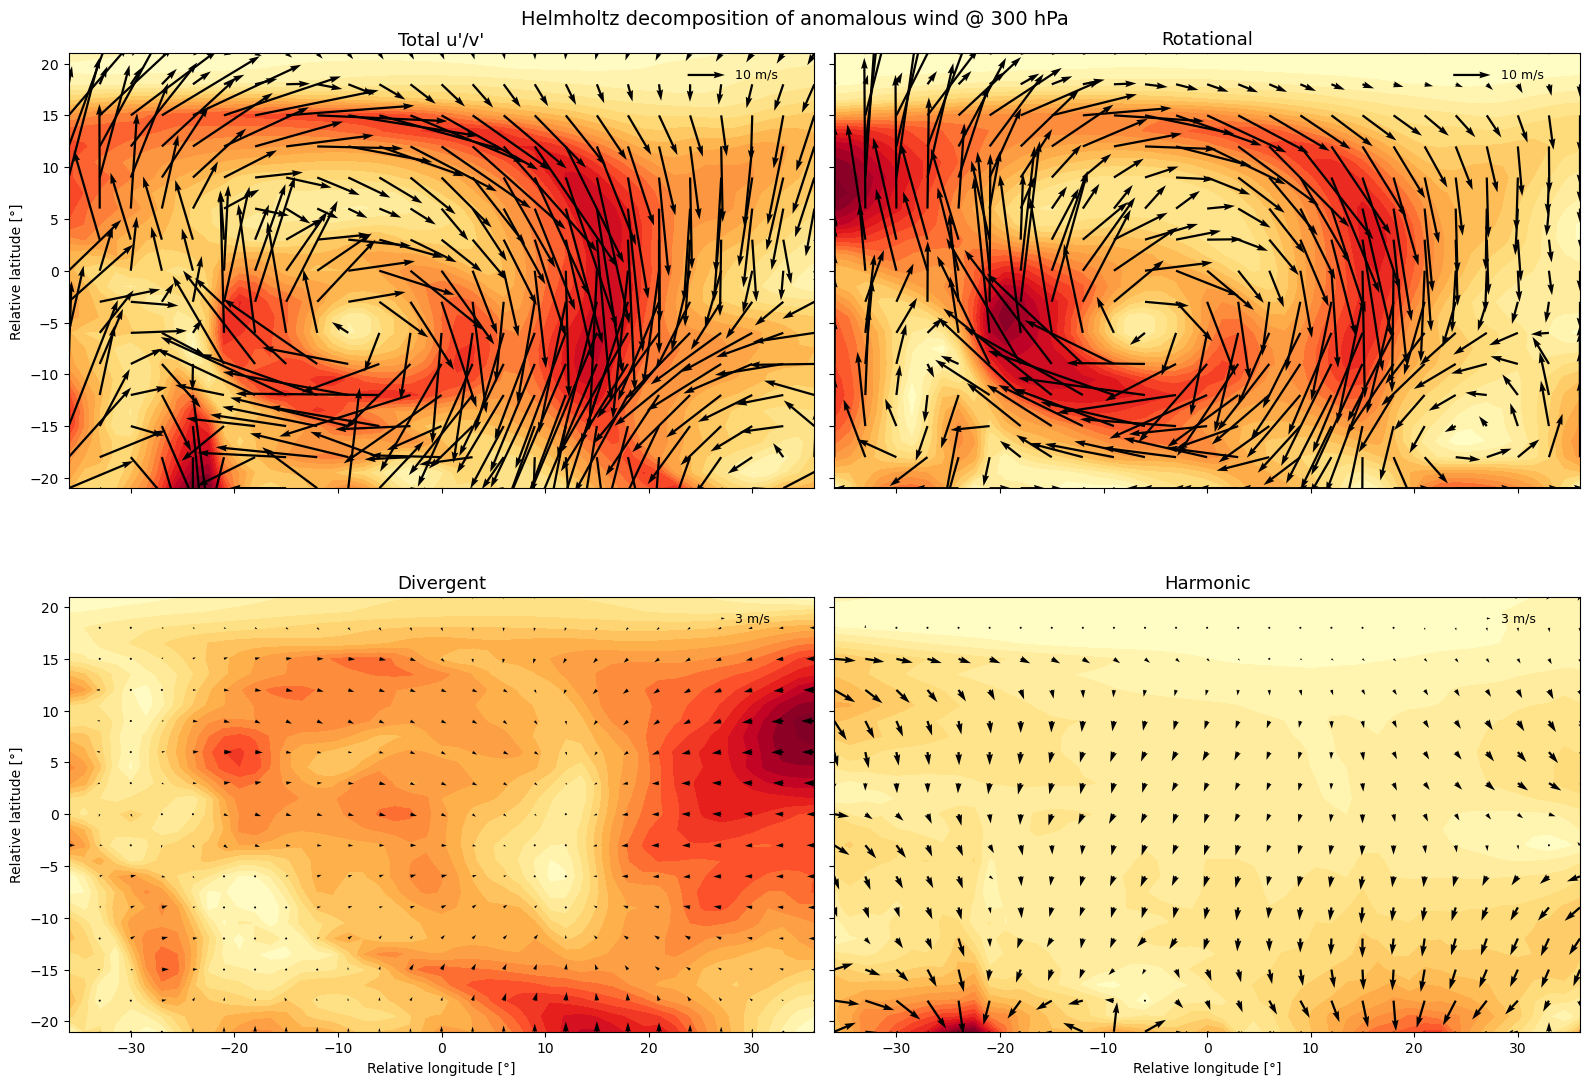

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True, sharex=True)
skip = 2
x, y = X_rel[0], Y_rel[:, 0]
xx, yy = np.meshgrid(x, y)

# Scales: Total & Rot share one scale; Div & Har share another
scale_strong = 200   # for Total and Rotational (larger vectors)
scale_weak   = 600   # for Divergent and Harmonic (smaller vectors)

panels = [
    (axes[0, 0], "Total u'/v'",   u_anom_3d[ilev],          v_anom_3d[ilev],          scale_strong),
    (axes[0, 1], "Rotational",    result_3d["u_rot"][ilev],  result_3d["v_rot"][ilev],  scale_strong),
    (axes[1, 0], "Divergent",     result_3d["u_div"][ilev],  result_3d["v_div"][ilev],  scale_weak),
    (axes[1, 1], "Harmonic",      result_3d["u_har"][ilev],  result_3d["v_har"][ilev],  scale_weak),
]

for ax, title, uk, vk, sc in panels:
    speed = np.sqrt(uk**2 + vk**2)
    ax.contourf(x, y, speed, levels=20, cmap="YlOrRd", extend="max")
    Q = ax.quiver(xx[::skip, ::skip], yy[::skip, ::skip],
                  uk[::skip, ::skip], vk[::skip, ::skip],
                  scale=sc, width=0.003, color="k")
    # Legend arrow length: 10 m/s for strong panels, 3 m/s for weak panels
    ref_val = 10.0 if sc == scale_strong else 3.0
    ax.quiverkey(Q, 0.88, 0.95, ref_val, f"{ref_val:.0f} m/s",
                 labelpos="E", coordinates="axes", fontproperties={"size": 9})
    ax.set_title(title, fontsize=13)
    ax.set_aspect("equal")

for ax in axes[:, 0]:
    ax.set_ylabel("Relative latitude [°]")
for ax in axes[1, :]:
    ax.set_xlabel("Relative longitude [°]")
fig.suptitle("Helmholtz decomposition of anomalous wind @ 300 hPa", y=0.93, fontsize=14)
fig.tight_layout()
plt.show()

## 4  QG omega equation — two solver methods

`solve_qg_omega` supports two methods:
- **`method="fft"`** (default): FFT in longitude + Thomas tridiagonal in pressure. Drops ∂²ω/∂y².
- **`method="direct"`**: Full 3-D sparse operator (BiCGSTAB+ILU). Retains both horizontal derivatives.

Optional `center_lat` parameter uses constant f₀ at event centre (Li & O'Gorman 2020 style).

In [16]:
import time

u_3d = d["u_3d"]
v_3d = d["v_3d"]
t_3d = d["t_3d"]
plevs_pa = levels.astype(float) * 100.0
center_lat = float(d["center_lat"]) if "center_lat" in d else float(np.mean(lat))

# --- Method A: FFT + Thomas (default) ---
t0 = time.perf_counter()
omega_fft = solve_qg_omega(u_3d, v_3d, t_3d, lat, lon, plevs_pa,
                           method="fft", center_lat=center_lat)
t_fft = time.perf_counter() - t0

# --- Method B: 3-D direct (BiCGSTAB+ILU) ---
t0 = time.perf_counter()
omega_direct = solve_qg_omega(u_3d, v_3d, t_3d, lat, lon, plevs_pa,
                              method="direct", center_lat=center_lat)
t_direct = time.perf_counter() - t0

# --- Pipeline-stored w_dry ---
omega_stored = d["w_dry_3d"]

print(f"FFT solver:      {t_fft:.2f} s  |  range [{omega_fft.min():.3e}, {omega_fft.max():.3e}] Pa/s")
print(f"3-D solver:      {t_direct:.2f} s  |  range [{omega_direct.min():.3e}, {omega_direct.max():.3e}] Pa/s")
print(f"Pipeline stored:              |  range [{omega_stored.min():.3e}, {omega_stored.max():.3e}] Pa/s")

mask = np.abs(omega_stored[1:-1]) > 1e-10
r_fft_3d = np.corrcoef(omega_fft[1:-1][mask].ravel(), omega_direct[1:-1][mask].ravel())[0, 1]
r_fft_st = np.corrcoef(omega_fft[1:-1][mask].ravel(), omega_stored[1:-1][mask].ravel())[0, 1]
r_3d_st  = np.corrcoef(omega_direct[1:-1][mask].ravel(), omega_stored[1:-1][mask].ravel())[0, 1]
print(f"\nCorrelations:  FFT↔3D = {r_fft_3d:.4f}  |  FFT↔stored = {r_fft_st:.4f}  |  3D↔stored = {r_3d_st:.4f}")

FFT solver:      0.01 s  |  range [-3.947e+01, 3.952e+01] Pa/s
3-D solver:      0.25 s  |  range [-3.992e+00, 4.049e+00] Pa/s
Pipeline stored:              |  range [-8.249e+00, 1.429e+01] Pa/s

Correlations:  FFT↔3D = 0.7476  |  FFT↔stored = 0.1778  |  3D↔stored = 0.2587


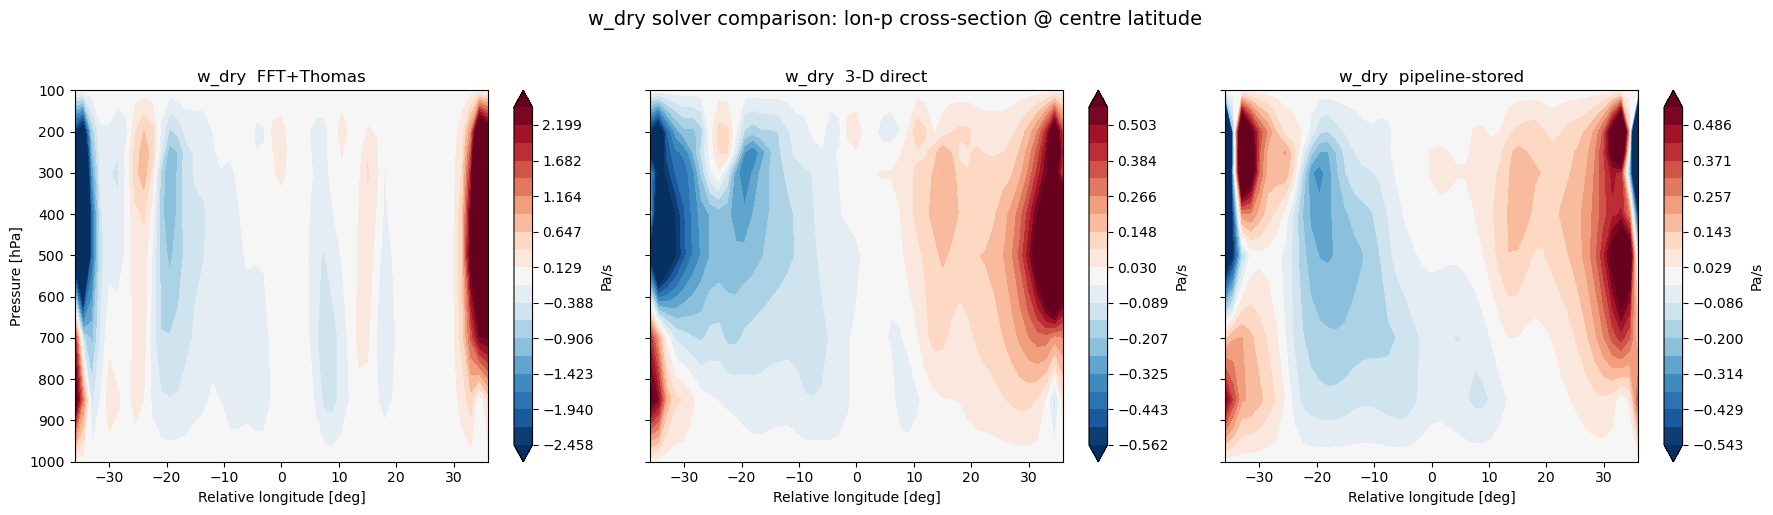

In [17]:
# --- Solver comparison: lon-pressure cross-section through blocking centre ---
imid_lat = lat.shape[0] // 2

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
solver_data = [
    ("w_dry  FFT+Thomas", omega_fft),
    ("w_dry  3-D direct", omega_direct),
    ("w_dry  pipeline-stored", omega_stored),
]

for ax, (title, omega) in zip(axes, solver_data):
    vmax = np.nanpercentile(np.abs(omega[:, imid_lat, :]), 95)
    if vmax < 1e-15:
        vmax = 1.0
    cf = ax.contourf(x, levels, omega[:, imid_lat, :],
                     levels=np.linspace(-vmax, vmax, 20), cmap="RdBu_r", extend="both")
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Relative longitude [deg]")
    plt.colorbar(cf, ax=ax, label="Pa/s")

axes[0].set_ylabel("Pressure [hPa]")
axes[0].invert_yaxis()
fig.suptitle("w_dry solver comparison: lon-p cross-section @ centre latitude", y=1.02, fontsize=14)
fig.tight_layout()
plt.show()

In [19]:
# --- With center_lat (Li & O'Gorman 2020 style: constant f0 at event centre) ---
center_lat = float(np.mean(lat))  # approximate event centre

omega_fft_cl = solve_qg_omega(
    u_3d, v_3d, t_3d, lat, lon, plevs_pa,
    method="fft", center_lat=center_lat
)
omega_3d_cl = solve_qg_omega(
    u_3d, v_3d, t_3d, lat, lon, plevs_pa,
    method="direct", center_lat=center_lat
)

mask_cl = np.abs(omega_fft_cl[1:-1]) > 1e-10
corr_cl = np.corrcoef(omega_fft_cl[1:-1][mask_cl].ravel(), omega_3d_cl[1:-1][mask_cl].ravel())[0, 1]
print(f"With center_lat={center_lat:.1f}:")
print(f"  FFT range:    [{omega_fft_cl.min():.3e}, {omega_fft_cl.max():.3e}]")
print(f"  Direct range: [{omega_3d_cl.min():.3e}, {omega_3d_cl.max():.3e}]")
print(f"  FFT vs 3-D:   r = {corr_cl:.4f}")

With center_lat=66.0:
  FFT range:    [-3.955e+01, 3.960e+01]
  Direct range: [-3.994e+00, 4.052e+00]
  FFT vs 3-D:   r = 0.7476


## 5  Complete omega decomposition cross-sections

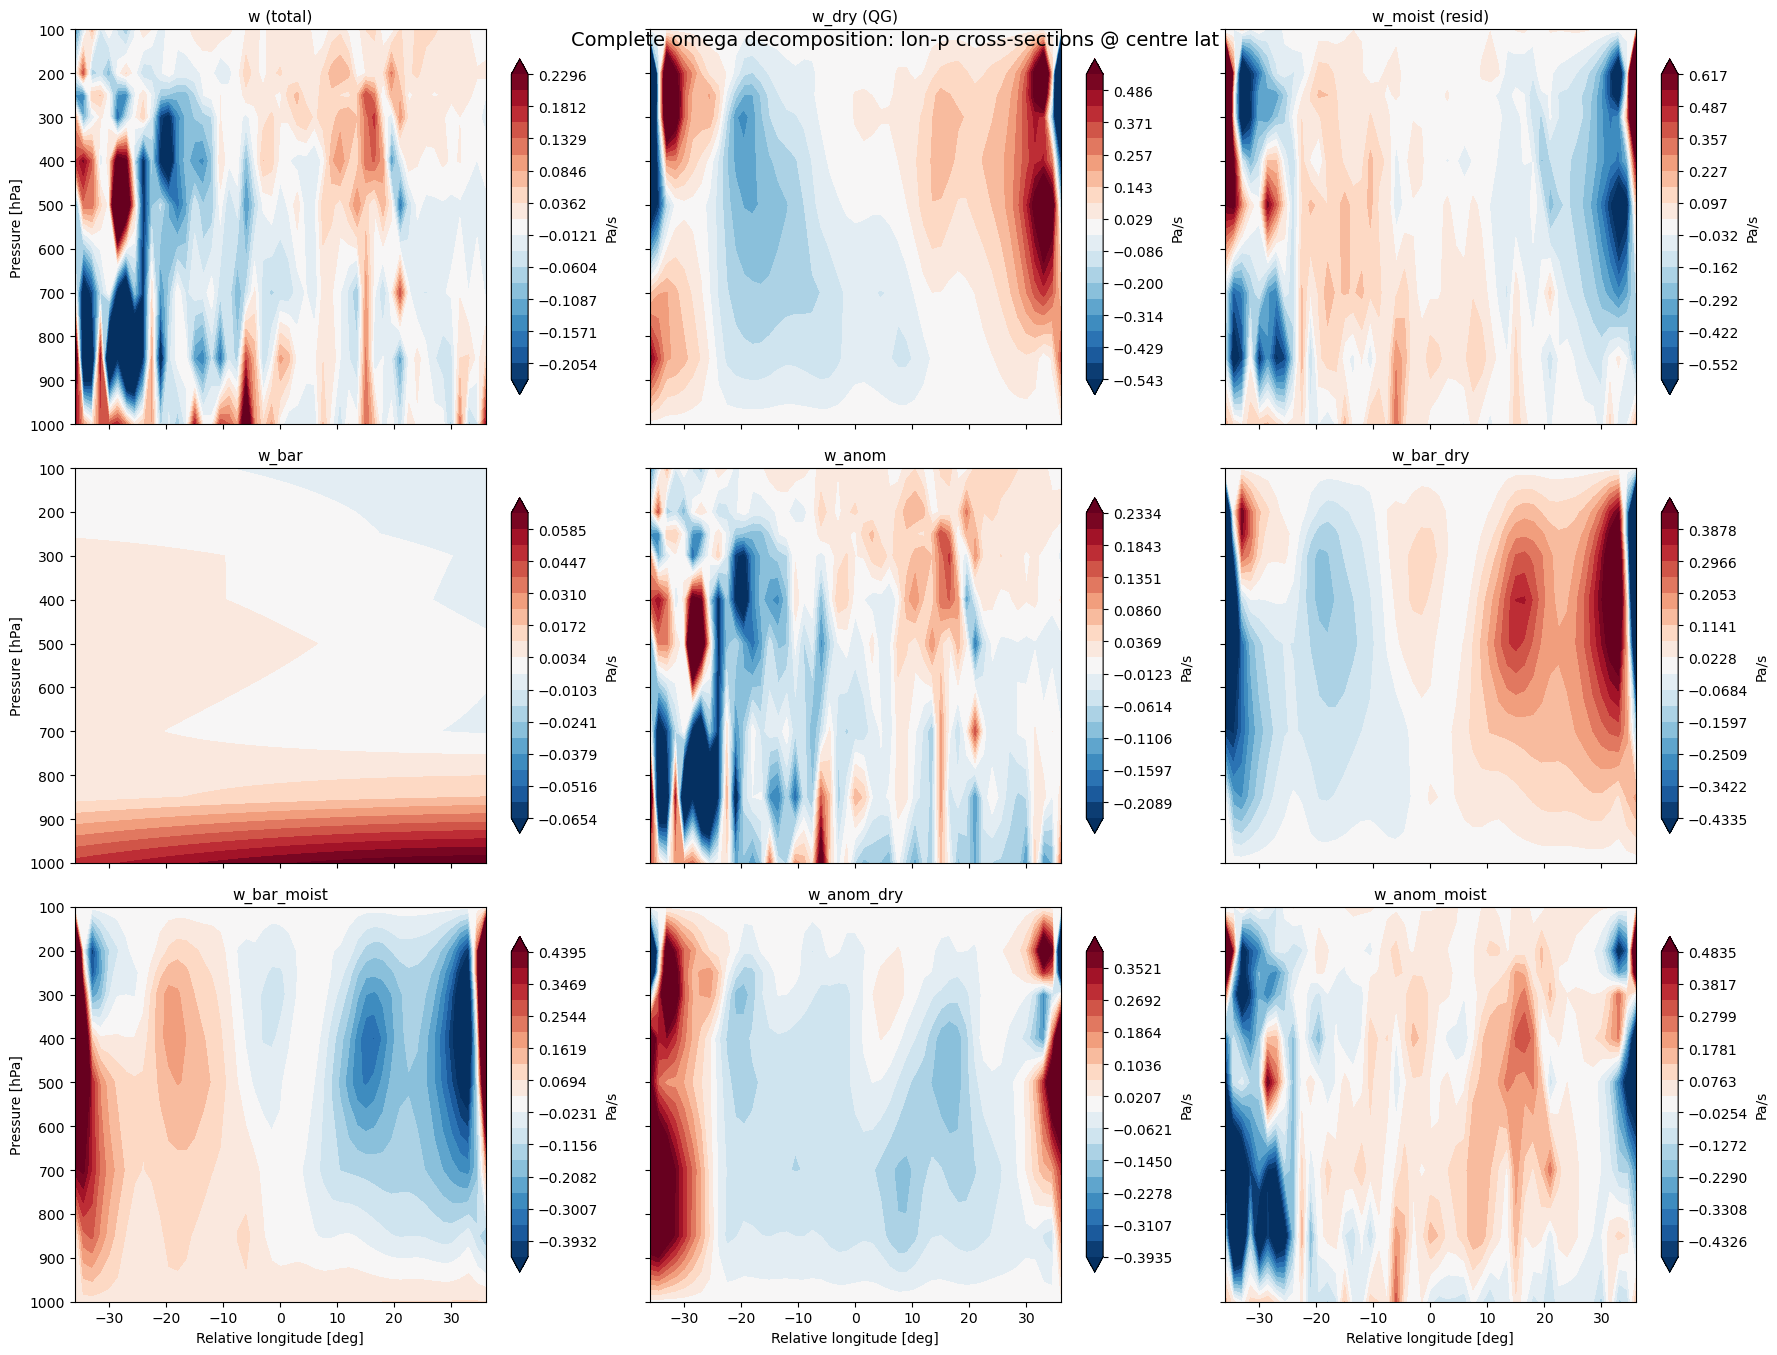

In [20]:
# Full omega decomposition: lon-p cross-sections through blocking centre
imid_lat = lat.shape[0] // 2

fields = [
    ("w (total)",       d["w_3d"]),
    ("w_dry (QG)",      d["w_dry_3d"]),
    ("w_moist (resid)", d["w_moist_3d"]),
    ("w_bar",           d["w_bar_3d"]),
    ("w_anom",          d["w_anom_3d"]),
    ("w_bar_dry",       d["w_bar_dry_3d"]),
    ("w_bar_moist",     d["w_bar_moist_3d"]),
    ("w_anom_dry",      d["w_anom_dry_3d"]),
    ("w_anom_moist",    d["w_anom_moist_3d"]),
]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 14), sharey=True, sharex=True)

for idx, (title, omega) in enumerate(fields):
    ax = axes.flat[idx]
    cross = omega[:, imid_lat, :]
    vmax = np.nanpercentile(np.abs(cross), 95)
    if vmax < 1e-15:
        vmax = 1.0
    cf = ax.contourf(x, levels, cross,
                     levels=np.linspace(-vmax, vmax, 20), cmap="RdBu_r", extend="both")
    ax.set_title(title, fontsize=11)
    plt.colorbar(cf, ax=ax, label="Pa/s", shrink=0.85)

axes[0, 0].invert_yaxis()
for ax in axes[:, 0]:
    ax.set_ylabel("Pressure [hPa]")
for ax in axes[-1, :]:
    ax.set_xlabel("Relative longitude [deg]")
fig.suptitle("Complete omega decomposition: lon-p cross-sections @ centre lat", y=0.95, fontsize=14)
fig.tight_layout()
plt.show()

## 6  Full variable decomposition summary & divergent wind dry/moist

In [21]:
# Full variable decomposition summary
omega_total = d["w_3d"]
omega_dry   = d["w_dry_3d"]

decomp = decompose_omega(omega_total, omega_dry, lat, lon, plevs_pa,
                         u_div=result_3d["u_div"], v_div=result_3d["v_div"])
print("decompose_omega keys:", sorted(decomp.keys()))

# Print ranges for all stored decomposition fields
print("\n--- Omega (w) decomposition ---")
for name in ["w_3d", "w_dry_3d", "w_moist_3d",
             "w_bar_3d", "w_anom_3d",
             "w_bar_dry_3d", "w_bar_moist_3d",
             "w_anom_dry_3d", "w_anom_moist_3d"]:
    arr = d[name]
    print(f"  {name:20s}  shape={arr.shape}  range=[{arr.min():.3e}, {arr.max():.3e}]")

# Divergent wind decomposition
print("\n--- Divergent wind decomposition (300 hPa) ---")
for name in ["u_anom_div_3d", "v_anom_div_3d",
             "u_anom_div_dry_3d", "v_anom_div_dry_3d",
             "u_anom_div_moist_3d", "v_anom_div_moist_3d"]:
    arr = d[name]
    print(f"  {name:25s}  shape={arr.shape}  range=[{arr.min():.3e}, {arr.max():.3e}]")

# Helmholtz wind decomposition
print("\n--- Helmholtz wind decomposition (300 hPa) ---")
for name in ["u_anom_rot_3d", "v_anom_rot_3d",
             "u_anom_div_3d", "v_anom_div_3d",
             "u_anom_har_3d", "v_anom_har_3d"]:
    arr = d[name]
    print(f"  {name:25s}  shape={arr.shape}  range=[{arr.min():.3e}, {arr.max():.3e}]")

decompose_omega keys: ['chi_moist', 'omega_moist', 'u_div_dry', 'u_div_moist', 'v_div_dry', 'v_div_moist']

--- Omega (w) decomposition ---
  w_3d                  shape=(9, 29, 49)  range=[-2.417e+00, 1.785e+00]
  w_dry_3d              shape=(9, 29, 49)  range=[-8.249e+00, 1.429e+01]
  w_moist_3d            shape=(9, 29, 49)  range=[-1.443e+01, 8.055e+00]
  w_bar_3d              shape=(9, 29, 49)  range=[-4.654e-02, 2.385e-01]
  w_anom_3d             shape=(9, 29, 49)  range=[-2.371e+00, 1.731e+00]
  w_bar_dry_3d          shape=(9, 29, 49)  range=[-4.341e+00, 9.267e+00]
  w_bar_moist_3d        shape=(9, 29, 49)  range=[-9.280e+00, 4.350e+00]
  w_anom_dry_3d         shape=(9, 29, 49)  range=[-4.203e+00, 8.103e+00]
  w_anom_moist_3d       shape=(9, 29, 49)  range=[-8.182e+00, 4.004e+00]

--- Divergent wind decomposition (300 hPa) ---
  u_anom_div_3d              shape=(9, 29, 49)  range=[-8.341e+00, 1.541e+01]
  v_anom_div_3d              shape=(9, 29, 49)  range=[-8.300e+00, 7.080e+00]

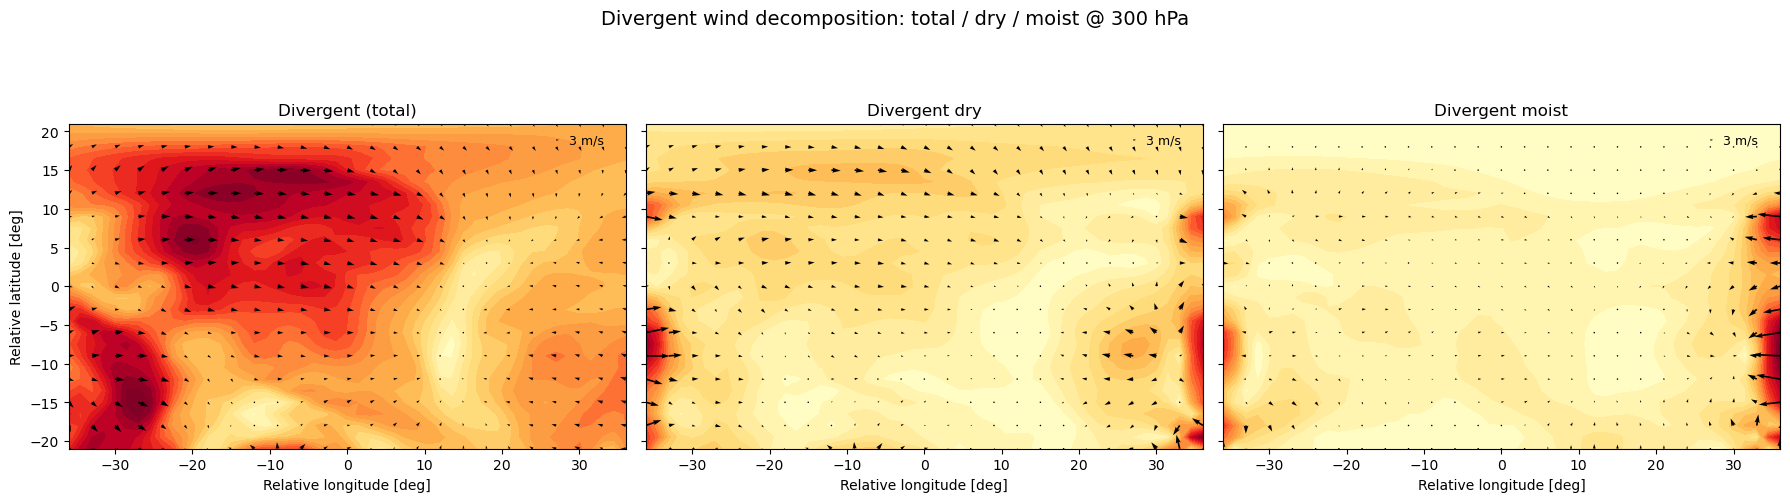

In [22]:
# Divergent wind: total vs dry vs moist at 300 hPa
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
skip = 2

div_panels = [
    ("Divergent (total)", d["u_anom_div_3d"][ilev], d["v_anom_div_3d"][ilev]),
    ("Divergent dry",     d["u_anom_div_dry_3d"][ilev], d["v_anom_div_dry_3d"][ilev]),
    ("Divergent moist",   d["u_anom_div_moist_3d"][ilev], d["v_anom_div_moist_3d"][ilev]),
]

for ax, (title, uk, vk) in zip(axes, div_panels):
    speed = np.sqrt(uk**2 + vk**2)
    ax.contourf(x, y, speed, levels=20, cmap="YlOrRd", extend="max")
    Q = ax.quiver(xx[::skip, ::skip], yy[::skip, ::skip],
                  uk[::skip, ::skip], vk[::skip, ::skip],
                  scale=600, width=0.003, color="k")
    ax.quiverkey(Q, 0.88, 0.95, 3.0, "3 m/s",
                 labelpos="E", coordinates="axes", fontproperties={"size": 9})
    ax.set_title(title, fontsize=12)
    ax.set_aspect("equal")

axes[0].set_ylabel("Relative latitude [deg]")
for ax in axes:
    ax.set_xlabel("Relative longitude [deg]")
fig.suptitle("Divergent wind decomposition: total / dry / moist @ 300 hPa", y=1.02, fontsize=14)
fig.tight_layout()
plt.show()

## Summary

- **`helmholtz_decomposition_3d`** splits anomalous wind into rotational (psi),
  divergent (chi) and harmonic residual at every pressure level.
- **`solve_qg_omega`** solves the QG omega equation with **two methods**:
  - `method="fft"` — FFT + Thomas tridiagonal (fast, drops d2w/dy2)
  - `method="direct"` — Full 3-D sparse BiCGSTAB+ILU (retains full horizontal Laplacian)
  - Optional `center_lat` for constant f0 at event centre (Li and O'Gorman 2020)
- **`decompose_omega`** partitions w into dry (QG) and moist (residual) parts,
  optionally computing the divergent-wind contribution of each.
- **Complete decomposition shown**: w_total / w_dry / w_moist / w_bar / w_anom /
  w_bar_dry / w_bar_moist / w_anom_dry / w_anom_moist, plus divergent wind dry/moist split.